In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change to project directory
import os
os.chdir('/content/drive/MyDrive/TwitterSentimentProject')

# Verify we're in the right place
print("Current directory:", os.getcwd())
print("\nContents:")
!ls -lh

Current directory: /content/drive/MyDrive/TwitterSentimentProject

Contents:
total 20K
drwx------ 2 root root 4.0K Dec 16 12:28 data
drwx------ 2 root root 4.0K Dec 16 17:24 models
drwx------ 2 root root 4.0K Dec 16 12:28 notebooks
drwx------ 2 root root 4.0K Dec 16 17:15 results
drwx------ 2 root root 4.0K Dec 20 12:23 twitter-sentiment-analysis


In [4]:
import os

dataset_path = 'data/raw/training.1600000.processed.noemoticon.csv'

if os.path.exists(dataset_path):
  file_size = os.path.getsize(dataset_path) / (1024**2)
  print(f"✅ Dataset found!")
  print(f"📁 Location: {dataset_path}")
  print(f"💾 Size: {file_size:.2f} MB")
else:
  print("❌ Dataset not found! Please check the path.")

✅ Dataset found!
📁 Location: data/raw/training.1600000.processed.noemoticon.csv
💾 Size: 227.74 MB


In [5]:
# Install any missing libraries
!pip install wordcloud -q

print("Installing complete!")

Installing complete!


In [6]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data (for later preprocessing)
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [7]:
# Define column names (Sentiment140 doesn't have headers)
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Load dataset
# Start with 100K rows for faster testing (remove nrows later for full dataset)
print("Loading dataset...")
df = pd.read_csv('data/raw/training.1600000.processed.noemoticon.csv',
                 encoding='latin-1',
                 names=columns,
                 nrows=100000)

print(f"✅ Dataset loaded!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nFirst 3 rows:")
df.head(3)

Loading dataset...
✅ Dataset loaded!
Shape: 100,000 rows × 6 columns

First 3 rows:


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds


In [8]:
# Dataset overview
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumns: {list(df.columns)}")

print("\n" + "="*70)
print("FIRST 3 ROWS")
print("="*70)
display(df.head(3))

print("\n" + "="*70)
print("DATASET INFO")
print("="*70)
df.info()

print("\n" + "="*70)
print("MISSING VALUES")
print("="*70)
print(df.isnull().sum())

DATASET OVERVIEW
Total rows: 100,000
Total columns: 6

Columns: ['sentiment', 'id', 'date', 'query', 'user', 'text']

FIRST 3 ROWS


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds



DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  100000 non-null  int64 
 1   id         100000 non-null  int64 
 2   date       100000 non-null  object
 3   query      100000 non-null  object
 4   user       100000 non-null  object
 5   text       100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB

MISSING VALUES
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64


In [9]:
# Display sample tweets from BOTH sentiments
print("="*70)
print("SAMPLE POSITIVE TWEETS (sentiment = 1)")
print("="*70)
for i, text in enumerate(df[df['sentiment']==1]['text'].head(5), 1):
    print(f"{i}. {text}\n")

print("="*70)
print("SAMPLE NEGATIVE TWEETS (sentiment = 0)")
print("="*70)
for i, text in enumerate(df[df['sentiment']==0]['text'].head(5), 1):
    print(f"{i}. {text}\n")

SAMPLE POSITIVE TWEETS (sentiment = 1)
SAMPLE NEGATIVE TWEETS (sentiment = 0)
1. @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

2. is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

3. @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

4. my whole body feels itchy and like its on fire 

5. @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 



In [10]:
# Calculate tweet lengths and word counts
df['tweet_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print("="*70)
print("TWEET LENGTH STATISTICS BY SENTIMENT")
print("="*70)
print("\nCharacter Length:")
print(df.groupby('sentiment')['tweet_length'].describe().round(2))

print("\n" + "="*70)
print("Word Count:")
print(df.groupby('sentiment')['word_count'].describe().round(2))

TWEET LENGTH STATISTICS BY SENTIMENT

Character Length:
              count   mean    std  min   25%   50%    75%    max
sentiment                                                       
0          100000.0  73.78  36.74  6.0  43.0  69.0  104.0  186.0

Word Count:
              count  mean   std  min  25%   50%   75%   max
sentiment                                                  
0          100000.0  13.5  7.07  1.0  8.0  13.0  19.0  35.0


ValueError: 'labels' must be of length 'x', not 2

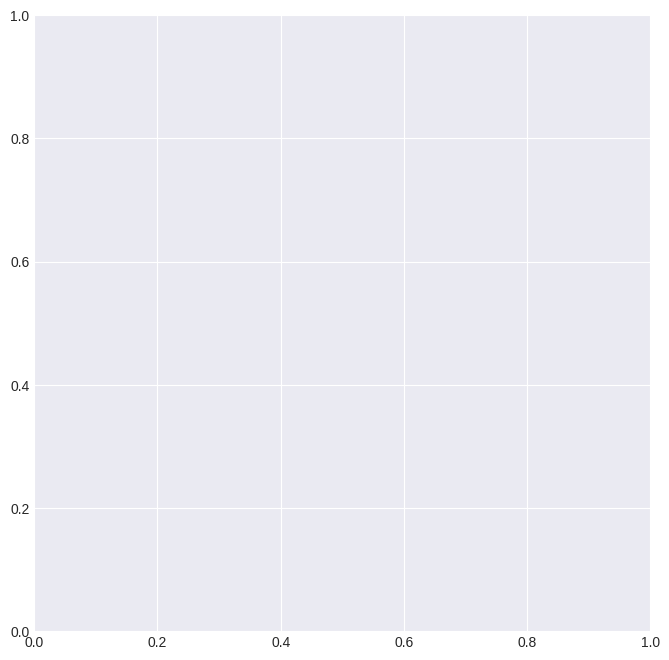

In [11]:
# Create results/figures folder if it doesn't exist
!mkdir -p results/figures

# Sentiment Distribution Pie Chart
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(10, 8))
colors = ['#e74c3c', '#2ecc71']  # Red, Green
explode = (0.05, 0.05)

plt.pie(sentiment_counts.values,
        labels=['Negative', 'Positive'],
        autopct='%1.1f%%',
        colors=colors,
        explode=explode,
        startangle=90,
        textprops={'fontsize': 14, 'fontweight': 'bold'})

plt.title('Sentiment Distribution in Dataset',
          fontsize=16, fontweight='bold', pad=20)

plt.savefig('results/figures/01_sentiment_distribution.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/01_sentiment_distribution.png")

In [ ]:
# Tweet Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Character length
axes[0].hist(df[df['sentiment']==0]['tweet_length'],
             bins=50, alpha=0.6, label='Negative', color='#e74c3c')
axes[0].hist(df[df['sentiment']==1]['tweet_length'],
             bins=50, alpha=0.6, label='Positive', color='#2ecc71')
axes[0].set_xlabel('Tweet Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Tweet Lengths', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Word count
axes[1].hist(df[df['sentiment']==0]['word_count'],
             bins=30, alpha=0.6, label='Negative', color='#e74c3c')
axes[1].hist(df[df['sentiment']==1]['word_count'],
             bins=30, alpha=0.6, label='Positive', color='#2ecc71')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/02_tweet_length_distribution.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/02_tweet_length_distribution.png")

In [12]:
# Function to extract clean words
def get_words(text):
    words = text.lower().split()
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
    words = [word for word in words if word and len(word) > 2]
    return words

# Extract words from both sentiments
print("Extracting words from tweets...")
print("(This may take 1-2 minutes)\n")

positive_words = []
negative_words = []

for text in df[df['sentiment']==1]['text']:
    positive_words.extend(get_words(text))

for text in df[df['sentiment']==0]['text']:
    negative_words.extend(get_words(text))

print(f"✅ Positive words extracted: {len(positive_words):,}")
print(f"✅ Negative words extracted: {len(negative_words):,}")

# Get top 20 most common words
positive_word_freq = Counter(positive_words).most_common(20)
negative_word_freq = Counter(negative_words).most_common(20)

print(f"\n{'='*70}")
print("TOP 10 POSITIVE WORDS:")
for word, count in positive_word_freq[:10]:
    print(f"  {word}: {count:,}")

print(f"\n{'='*70}")
print("TOP 10 NEGATIVE WORDS:")
for word, count in negative_word_freq[:10]:
    print(f"  {word}: {count:,}")

Extracting words from tweets...
(This may take 1-2 minutes)

✅ Positive words extracted: 0
✅ Negative words extracted: 997,169

TOP 10 POSITIVE WORDS:

TOP 10 NEGATIVE WORDS:
  the: 31,904
  and: 19,292
  for: 12,301
  you: 10,900
  have: 10,293
  but: 9,909
  not: 9,109
  that: 8,666
  just: 7,705
  was: 7,403


ValueError: not enough values to unpack (expected 2, got 0)

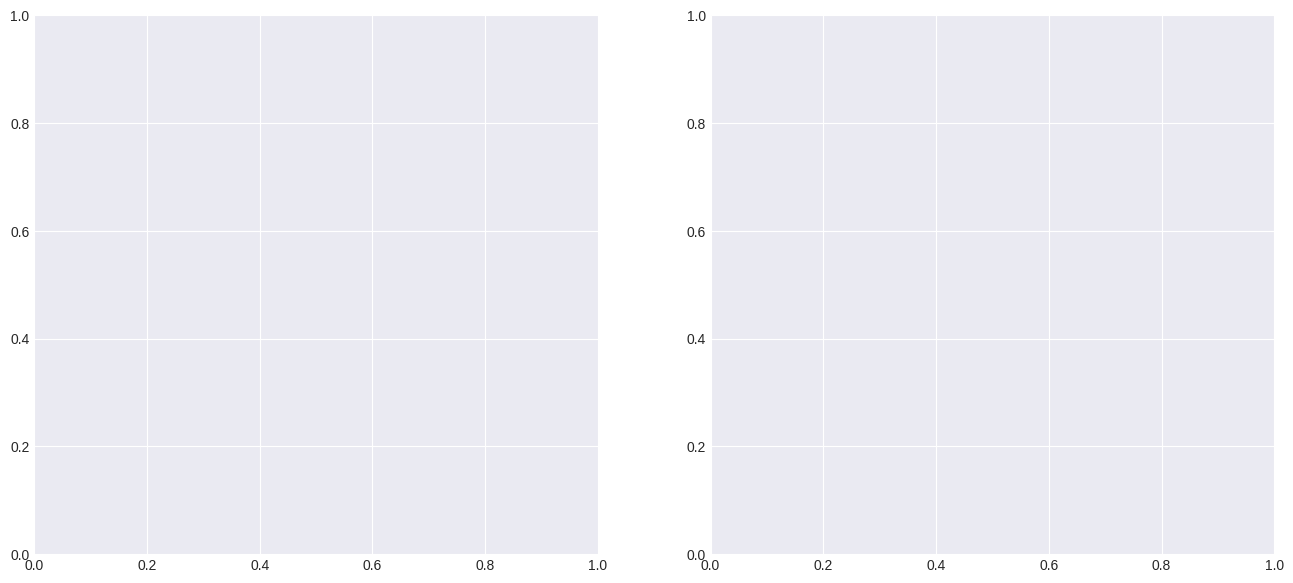

In [13]:
# Plot top words for both sentiments
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Positive words
pos_words, pos_counts = zip(*positive_word_freq)
axes[0].barh(range(len(pos_words)), pos_counts, color='#2ecc71', alpha=0.8)
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words, fontsize=11)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 20 Words in Positive Tweets',
                  fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Negative words
neg_words, neg_counts = zip(*negative_word_freq)
axes[1].barh(range(len(neg_words)), neg_counts, color='#e74c3c', alpha=0.8)
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words, fontsize=11)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 20 Words in Negative Tweets',
                  fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/03_top_words.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/03_top_words.png")

In [ ]:
from wordcloud import WordCloud

# Create word clouds for both sentiments
print("Generating word clouds...")

positive_text = ' '.join(positive_words)
negative_text = ' '.join(negative_words)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Positive word cloud
wordcloud_pos = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Greens',
                          max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Tweets Word Cloud',
                  fontsize=16, fontweight='bold', pad=10)

# Negative word cloud
wordcloud_neg = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Reds',
                          max_words=100).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Tweets Word Cloud',
                  fontsize=16, fontweight='bold', pad=10)

plt.tight_layout()
plt.savefig('results/figures/04_wordclouds.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/04_wordclouds.png")

In [ ]:
# Extract hashtags, mentions, URLs
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

def extract_mentions(text):
    return re.findall(r'@\w+', text.lower())

def has_url(text):
    return 1 if 'http' in text.lower() else 0

print("Analyzing tweet characteristics...")

df['hashtags'] = df['text'].apply(extract_hashtags)
df['mentions'] = df['text'].apply(extract_mentions)
df['hashtag_count'] = df['hashtags'].apply(len)
df['mention_count'] = df['mentions'].apply(len)
df['has_url'] = df['text'].apply(has_url)

print(f"\n{'='*70}")
print("TWEET CHARACTERISTICS")
print(f"{'='*70}")
print(f"Tweets with hashtags: {(df['hashtag_count'] > 0).sum():,} ({(df['hashtag_count'] > 0).mean()*100:.1f}%)")
print(f"Tweets with mentions: {(df['mention_count'] > 0).sum():,} ({(df['mention_count'] > 0).mean()*100:.1f}%)")
print(f"Tweets with URLs: {df['has_url'].sum():,} ({df['has_url'].mean()*100:.1f}%)")

print(f"\n✅ Characteristic analysis complete!")

In [ ]:
# Plot characteristics
characteristics_data = {
    'Has Hashtags': (df['hashtag_count'] > 0).mean() * 100,
    'Has Mentions': (df['mention_count'] > 0).mean() * 100,
    'Has URLs': df['has_url'].mean() * 100
}

plt.figure(figsize=(10, 7))
bars = plt.bar(characteristics_data.keys(),
               characteristics_data.values(),
               color=['#e74c3c', '#3498db', '#2ecc71'],
               alpha=0.8, edgecolor='black', linewidth=1.5)

plt.ylabel('Percentage of Tweets (%)', fontsize=12, fontweight='bold')
plt.title('Tweet Characteristics Distribution',
          fontsize=16, fontweight='bold', pad=15)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom',
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/05_tweet_characteristics.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/05_tweet_characteristics.png")

In [ ]:
# Data cleaning
print("="*70)
print("DATA CLEANING")
print("="*70)

original_size = len(df)

# 1. Remove duplicates
duplicates = df.duplicated(subset=['text']).sum()
print(f"\n1. Duplicate tweets: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
df_clean = df.drop_duplicates(subset=['text'], keep='first')
print(f"   After removal: {len(df_clean):,} tweets")

# 2. Remove very short tweets
short_tweets = (df_clean['word_count'] < 2).sum()
print(f"\n2. Very short tweets (<2 words): {short_tweets:,}")
df_clean = df_clean[df_clean['word_count'] >= 2]
print(f"   After removal: {len(df_clean):,} tweets")

# 3. Final stats
removed = original_size - len(df_clean)
print(f"\n{'='*70}")
print(f"CLEANING SUMMARY")
print(f"{'='*70}")
print(f"Original size: {original_size:,}")
print(f"Cleaned size: {len(df_clean):,}")
print(f"Removed: {removed:,} ({removed/original_size*100:.2f}%)")
print(f"\nFinal sentiment distribution:")
print(f"Negative: {(df_clean['sentiment']==0).sum():,} ({(df_clean['sentiment']==0).mean()*100:.1f}%)")
print(f"Positive: {(df_clean['sentiment']==1).sum():,} ({(df_clean['sentiment']==1).mean()*100:.1f}%)")

In [14]:
# Save cleaned dataset
output_path = 'data/processed/tweets_cleaned.csv'
df_clean.to_csv(output_path, index=False)

file_size = os.path.getsize(output_path) / (1024**2)

print(f"✅ Cleaned dataset saved!")
print(f"📁 Location: {output_path}")
print(f"💾 Size: {file_size:.2f} MB")
print(f"📊 Rows: {len(df_clean):,}")
print(f"📋 Columns: {len(df_clean.columns)}")

NameError: name 'df_clean' is not defined

In [ ]:
# Create summary statistics
summary = {
    'Metric': [
        'Total Tweets',
        'Positive Tweets',
        'Negative Tweets',
        'Avg Tweet Length (chars)',
        'Avg Word Count',
        'Min Tweet Length',
        'Max Tweet Length',
        'Tweets with Hashtags',
        'Tweets with Mentions',
        'Tweets with URLs',
        'Duplicates Removed',
        'Short Tweets Removed'
    ],
    'Value': [
        f"{len(df_clean):,}",
        f"{(df_clean['sentiment']==1).sum():,} ({(df_clean['sentiment']==1).mean()*100:.1f}%)",
        f"{(df_clean['sentiment']==0).sum():,} ({(df_clean['sentiment']==0).mean()*100:.1f}%)",
        f"{df_clean['tweet_length'].mean():.1f}",
        f"{df_clean['word_count'].mean():.1f}",
        f"{df_clean['tweet_length'].min()}",
        f"{df_clean['tweet_length'].max()}",
        f"{(df_clean['hashtag_count'] > 0).sum():,} ({(df_clean['hashtag_count'] > 0).mean()*100:.1f}%)",
        f"{(df_clean['mention_count'] > 0).sum():,} ({(df_clean['mention_count'] > 0).mean()*100:.1f}%)",
        f"{df_clean['has_url'].sum():,} ({df_clean['has_url'].mean()*100:.1f}%)",
        f"{duplicates:,}",
        f"{short_tweets:,}"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('results/dataset_summary.csv', index=False)

print("="*70)
print("DATASET SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print(f"\n✅ Summary saved to: results/dataset_summary.csv")

DATASET SUMMARY
                  Metric          Value
            Total Tweets         99,357
         Positive Tweets 49,739 (50.1%)
         Negative Tweets 49,618 (49.9%)
Avg Tweet Length (chars)           74.4
          Avg Word Count           13.2
        Min Tweet Length              7
        Max Tweet Length            323
    Tweets with Hashtags   2,273 (2.3%)
    Tweets with Mentions 46,145 (46.4%)
        Tweets with URLs   4,330 (4.4%)
      Duplicates Removed            298
    Short Tweets Removed            345

✅ Summary saved to: results/dataset_summary.csv


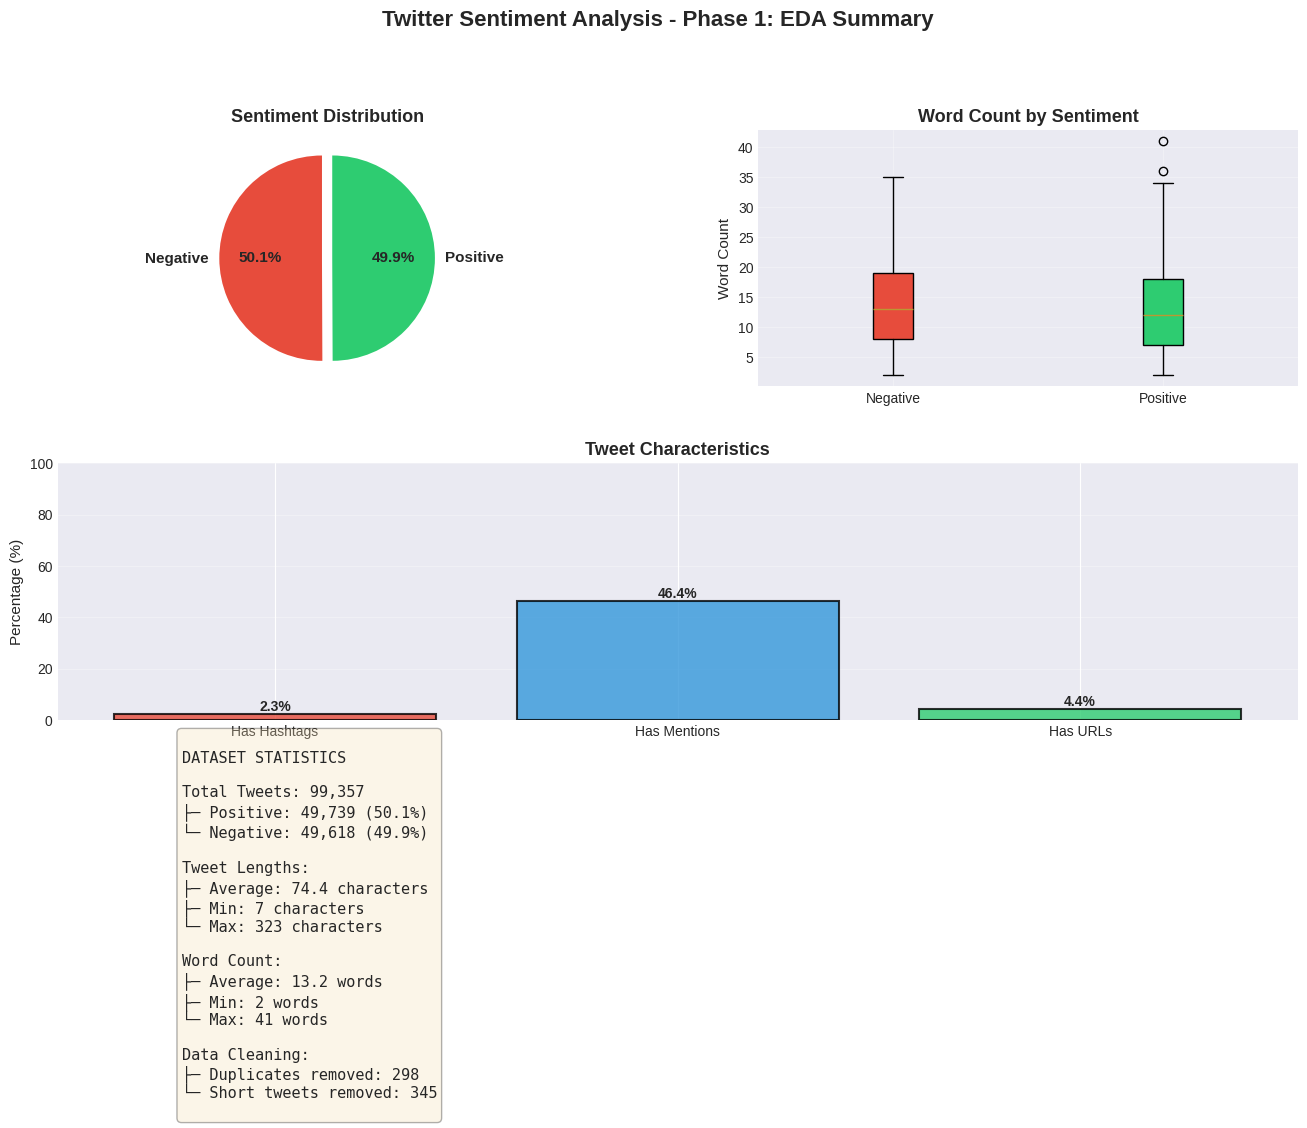

✅ Saved: results/figures/06_eda_summary.png


In [ ]:
# Comprehensive summary visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Sentiment Pie Chart
ax1 = fig.add_subplot(gs[0, 0])
sentiment_counts = df_clean['sentiment'].value_counts()
ax1.pie(sentiment_counts.values,
        labels=['Negative', 'Positive'],
        autopct='%1.1f%%',
        colors=['#e74c3c', '#2ecc71'],
        explode=(0.05, 0.05),
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Sentiment Distribution', fontsize=13, fontweight='bold')

# 2. Word Count Box Plot
ax2 = fig.add_subplot(gs[0, 1])
data_to_plot = [df_clean[df_clean['sentiment']==0]['word_count'],
                df_clean[df_clean['sentiment']==1]['word_count']]
bp = ax2.boxplot(data_to_plot, labels=['Negative', 'Positive'], patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][1].set_facecolor('#2ecc71')
ax2.set_ylabel('Word Count', fontsize=11)
ax2.set_title('Word Count by Sentiment', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Tweet Characteristics Bar
ax3 = fig.add_subplot(gs[1, :])
char_data = {
    'Has Hashtags': (df_clean['hashtag_count'] > 0).mean() * 100,
    'Has Mentions': (df_clean['mention_count'] > 0).mean() * 100,
    'Has URLs': df_clean['has_url'].mean() * 100
}
bars = ax3.bar(char_data.keys(), char_data.values(),
               color=['#e74c3c', '#3498db', '#2ecc71'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Percentage (%)', fontsize=11)
ax3.set_title('Tweet Characteristics', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

# 4. Summary Statistics Text
ax4 = fig.add_subplot(gs[2, :])
summary_text = f"""
DATASET STATISTICS

Total Tweets: {len(df_clean):,}
├─ Positive: {(df_clean['sentiment']==1).sum():,} ({(df_clean['sentiment']==1).mean()*100:.1f}%)
└─ Negative: {(df_clean['sentiment']==0).sum():,} ({(df_clean['sentiment']==0).mean()*100:.1f}%)

Tweet Lengths:
├─ Average: {df_clean['tweet_length'].mean():.1f} characters
├─ Min: {df_clean['tweet_length'].min()} characters
└─ Max: {df_clean['tweet_length'].max()} characters

Word Count:
├─ Average: {df_clean['word_count'].mean():.1f} words
├─ Min: {df_clean['word_count'].min()} words
└─ Max: {df_clean['word_count'].max()} words

Data Cleaning:
├─ Duplicates removed: {duplicates:,}
└─ Short tweets removed: {short_tweets:,}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round',
         facecolor='wheat', alpha=0.3))
ax4.axis('off')

fig.suptitle('Twitter Sentiment Analysis - Phase 1: EDA Summary',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('results/figures/06_eda_summary.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Saved: results/figures/06_eda_summary.png")

In [ ]:
# Final verification
print("="*70)
print("PHASE 1 OUTPUT VERIFICATION")
print("="*70)

# Check figures
figures_path = 'results/figures'
figures = sorted([f for f in os.listdir(figures_path) if f.endswith('.png')])
print(f"\n📊 Visualizations created ({len(figures)}):")
for i, fig in enumerate(figures, 1):
    size = os.path.getsize(f'{figures_path}/{fig}') / 1024
    print(f"  {i}. {fig} ({size:.1f} KB)")

# Check cleaned data
if os.path.exists('data/processed/tweets_cleaned.csv'):
    size = os.path.getsize('data/processed/tweets_cleaned.csv') / (1024**2)
    print(f"\n💾 Cleaned dataset:")
    print(f"  ✅ data/processed/tweets_cleaned.csv ({size:.2f} MB, {len(df_clean):,} rows)")

# Check summary
if os.path.exists('results/dataset_summary.csv'):
    print(f"\n📋 Summary report:")
    print(f"  ✅ results/dataset_summary.csv")

print(f"\n{'='*70}")
print("✅ PHASE 1 COMPLETE!")
print("   - Dataset loaded and balanced (50/50 split)")
print("   - 6visualizations created")
print("   - Data cleaned and saved")
print("   - Summary statistics generated")
print(f"{'='*70}")

PHASE 1 OUTPUT VERIFICATION

📊 Visualizations created (6):
  1. 01_sentiment_distribution.png (100.4 KB)
  2. 02_tweet_length_distribution.png (157.2 KB)
  3. 03_top_words.png (178.6 KB)
  4. 04_wordclouds.png (2443.7 KB)
  5. 05_tweet_characteristics.png (108.6 KB)
  6. 06_eda_summary.png (400.8 KB)

💾 Cleaned dataset:
  ✅ data/processed/tweets_cleaned.csv (15.45 MB, 99,357 rows)

📋 Summary report:
  ✅ results/dataset_summary.csv

✅ PHASE 1 COMPLETE!
   - Dataset loaded and balanced (50/50 split)
   - 6visualizations created
   - Data cleaned and saved
   - Summary statistics generated


In [15]:
%cd /content
!git clone https://github.com/zeynkash/twitter-sentiment-analysis.git


/content
Cloning into 'twitter-sentiment-analysis'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [16]:
!git config --global user.name "zeynkash"  # Replace with your name
!git config --global user.email "030721077@std.izu.edu.tr"

In [17]:
%cd /content/twitter-sentiment-analysis


/content/twitter-sentiment-analysis


In [21]:
!ls

README.md


In [22]:
!mkdir -p notebooks


In [20]:
!cp /content/drive/MyDrive/TwitterSentimentProject/notebooks/01_Phase1_EDA.ipynb notebooks/

cp: cannot create regular file 'notebooks/': Not a directory
